# Bra detection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [8]:
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img , img_to_array

import pandas as pd 
import numpy as np

import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.models import Sequential , Model , load_model

from tensorflow.keras.utils import to_categorical

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
def extract_label(img_path, flag):
    filename, extension = os.path.splitext(os.path.basename(img_path))
    
    subject_id, etc = filename.split("__") # 2 underscore
    bra = "without_bra"
    
    if flag:
        breast_size, waist_size, band_size, cup_size, with_bra = etc.split('_')
        
        if with_bra == 'true':
            bra = "with_bra"

        return bra
    else:
        breast_size, waist_size, band_size, cup_size = etc.split('_')
        return bra

In [11]:
bra_path = "./dataset/with_bra"
without_bra_path = "./dataset/without_bra"

img_size = 224

images = []
labels = []

In [12]:
for image in os.listdir(bra_path):
    img = cv2.imread(os.path.join(bra_path, image), cv2.IMREAD_COLOR)
    
    img_resize = cv2.resize(img, (img_size, img_size))
        
    # flag = 0 -> no bra
    # flag = 1 -> has bra
    label = extract_label(os.path.join(bra_path, image), True)
    
#     print(label)
    
    labels.append(label)
    images.append(img_resize);


In [13]:
for image in os.listdir(without_bra_path):
    img = cv2.imread(os.path.join(without_bra_path, image), cv2.IMREAD_COLOR)
    
    img_resize = cv2.resize(img, (img_size, img_size))
        
    # flag = 0 -> no bra
    # flag = 1 -> has bra
    label = extract_label(os.path.join(without_bra_path, image), False)
    
#     print(label)
    
    labels.append(label)
    images.append(img_resize);

In [14]:
unique_labels = unique_list = list(set(labels))

In [15]:
unique_labels

['with_bra', 'without_bra']

# Performing one-hot encoding on labels

In [16]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Convert image arry to np array

In [17]:
np_images = np.array(images).astype('float32')
np_labels = np.array(labels).astype('float32')

unique_labels = np.asarray(unique_labels)

In [18]:
print(np_images.shape)
print(np_labels.shape)

print(unique_labels.shape)

(530, 224, 224, 3)
(530, 2)
(2,)


In [19]:
X_train, X_val, y_train, y_val = train_test_split(np_images, np_labels, test_size = 0.3, random_state = 1)

In [20]:
img_gen = ImageDataGenerator(rotation_range=40,
                            zoom_range=0.20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode="nearest")

print("Train size: ",len(X_train),"Test size: ",len(X_val))

Train size:  371 Test size:  159


In [21]:
# debug 
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## MobileNetV2 acrchitecture

In [22]:
model = Sequential()
model.add(Conv2D(512,(2,2),padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(256,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(128,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(64,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(32,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

#model.add(BatchNormalization())

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(2,activation="softmax"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 512)     6656      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 512)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 256)     524544    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       131200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [24]:
history = model.fit(
    X_train,
    y_train,
    epochs = 32,
    steps_per_epoch=32,
    batch_size = 10,
    validation_data = (X_val, y_val), 
    validation_steps=5,
    validation_split=0.15
)

# history = model.fit(img_gen.flow(X_train,y_train,batch_size=5),
#                     steps_per_epoch=64,
#                     validation_data=(X_val,y_val),
#                     validation_steps=300,
#                     epochs=45)

Epoch 1/32
32/32 [==============================] - 78s 2s/step - loss: 5.1928 - accuracy: 0.5208 - val_loss: 0.6600 - val_accuracy: 0.6400
Epoch 2/32
32/32 [==============================] - 79s 2s/step - loss: 0.6915 - accuracy: 0.5749 - val_loss: 0.6591 - val_accuracy: 0.6400
Epoch 3/32
32/32 [==============================] - 80s 2s/step - loss: 0.6845 - accuracy: 0.5588 - val_loss: 0.6564 - val_accuracy: 0.6400
Epoch 4/32
32/32 [==============================] - 81s 3s/step - loss: 0.6771 - accuracy: 0.6236 - val_loss: 0.6432 - val_accuracy: 0.7000
Epoch 5/32
32/32 [==============================] - 81s 3s/step - loss: 0.6642 - accuracy: 0.6267 - val_loss: 0.6330 - val_accuracy: 0.6800
Epoch 6/32
32/32 [==============================] - 80s 3s/step - loss: 0.7034 - accuracy: 0.5350 - val_loss: 0.6182 - val_accuracy: 0.6800
Epoch 7/32
32/32 [==============================] - 79s 2s/step - loss: 0.6623 - accuracy: 0.5851 - val_loss: 0.6336 - val_accuracy: 0.6800
Epoch 8/32
32/32 [==

In [25]:
def plot_graph(history,string):
    plt.figure(figsize=(16,7))
    plt.plot(history.history[string],label=str(string))
    plt.plot(history.history["val_"+str(string)],label=str(string))
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()

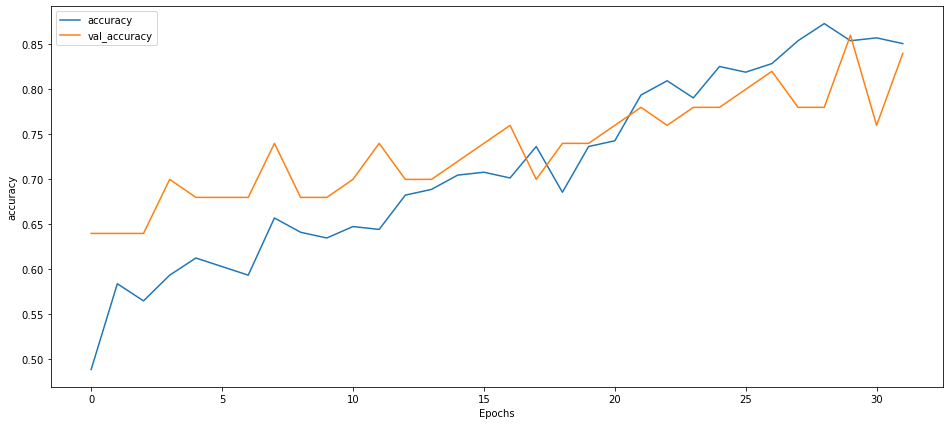

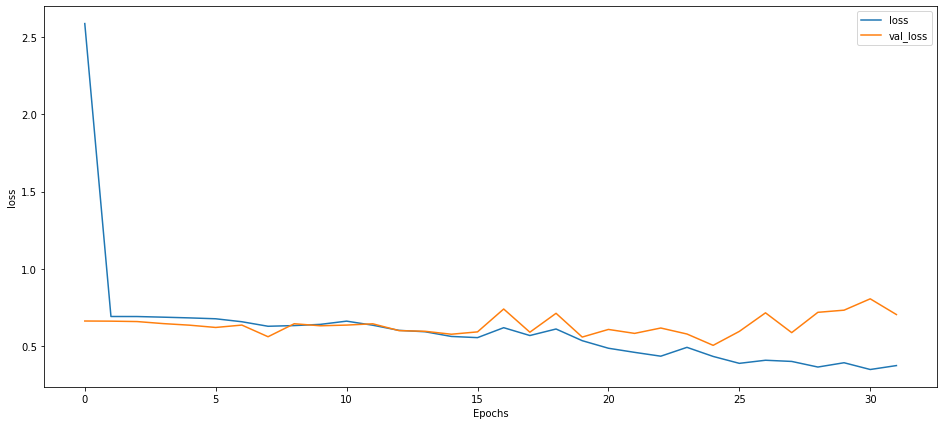

In [26]:
plot_graph(history,"accuracy")
plot_graph(history,"loss")

## Save model

In [27]:
model.save('/content/drive/MyDrive/datasets/dataset/bra_dection_mobileNetV2_improvised.h5')

## Test Result 

In [28]:
pred = model.predict(X_val)

In [29]:
print(pred[1])
print(y_val[10])

[2.4384156e-10 1.0000000e+00]
[0. 1.]


# Loading Testset

In [30]:
INPUT_IMAGE_SIZE = 224

def load_image(image_path):
    return tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=[INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE]
    )

In [31]:
def image_to_array(image):
    return tf.keras.preprocessing.image.img_to_array(image, dtype=np.int32)

In [32]:
def display_image(image_np):
    plt.figure()
    plt.imshow(image_np)

In [37]:
test_image_dir = './testsets/'
test_images = []

for image_path in os.listdir(test_image_dir):
    # <PIL.Image.Image image mode=RGB size=224x224 at 0x141247ED0>
    test_image = load_image(os.path.join(test_image_dir, image_path))
    test_image_array = image_to_array(test_image)
    test_images.append(test_image_array)

In [39]:
print(len(test_images))

35


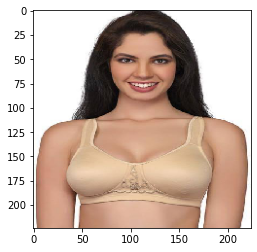

In [102]:
plt.figure()
plt.imshow(test_images[2]);

plt.show()

# Preprocess test images


In [107]:
test_images_preprocessed = []

In [108]:
def image_preprocess(image_array):
    return tf.keras.applications.mobilenet_v2.preprocess_input(
        image_array[tf.newaxis, ...]
    )

In [109]:
for test_image in test_images:
    test_image_preprocessed = image_preprocess(test_image)
    test_images_preprocessed.append(test_image_preprocessed)

In [110]:
print(len(test_images_preprocessed))

35


In [111]:
print('Image shape before preprocessing:', test_images[2].shape)
print('Image shape after preprocessing:', test_images_preprocessed[0].shape)

Image shape before preprocessing: (224, 224, 3)
Image shape after preprocessing: (1, 224, 224, 3)


In [113]:
print(test_images_preprocessed[2])

[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[0.9607843  0.9764706  0.96862745]
   [0.9607843  0.99215686 1.        ]
   [0.99215686 0.9843137  0.96862745]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.9764706  0.99215686 0.9843137 ]
   [0.9

## Classify one image

In [254]:
def get_tags(probs, labels, max_classes = 5, prob_threshold = 0.01):
    probs_mask = probs > prob_threshold
    probs_filtered = probs[probs_mask] * 100
    labels_filtered = labels[probs_mask]
    
    sorted_index = np.flip(np.argsort(probs_filtered))
    labels_filtered = labels_filtered[sorted_index][:max_classes]
    probs_filtered = probs_filtered[sorted_index][:max_classes].astype(np.int)
    
    tags = ''
    for i in range(0, len(labels_filtered)):
        tags = tags + labels_filtered[i] + ' (' + str(probs_filtered[i]) + '%), ' 

    return tags, labels_filtered, probs_filtered 

In [255]:
TEST_IMAGE_INDEX = 4

In [256]:
result = model(test_images_preprocessed[TEST_IMAGE_INDEX])

In [257]:
result.shape

TensorShape([1, 2])

In [258]:
print(result)

tf.Tensor([[0.2949378 0.7050622]], shape=(1, 2), dtype=float32)


In [259]:
np_result = result.numpy()[0]

In [260]:
print(np_result)

[0.2949378 0.7050622]


In [261]:
tags, labels_filtered, probs_filtered = get_tags(np_result, unique_labels)

In [262]:
print('probs_filtered:', probs_filtered)
print('labels_filtered:', labels_filtered)

probs_filtered: [70 29]
labels_filtered: ['with_bra' 'without_bra']


In [263]:
print(tags)

with_bra (70%), without_bra (29%), 


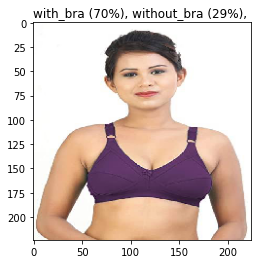

In [264]:
plt.figure()
plt.title(tags)
plt.imshow(test_images[TEST_IMAGE_INDEX]);

plt.show()

## ResNet-50 Architechture

In [265]:
base_model_resnet_50 = ResNet50(weights= None, 
                                include_top=False, 
                                input_shape= (img_size,img_size, 3)
                                )

In [267]:
num_classes = 2
x = base_model_resnet_50.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)

predictions = Dense(num_classes, activation="softmax")(x)

new_model = Model(inputs = base_model_resnet_50.input, outputs = predictions)

In [268]:
# model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
new_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [269]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [271]:
new_history= new_model.fit(X_train,
    y_train,
    epochs = 32,
    steps_per_epoch=32,
    batch_size = 10,
    validation_data = (X_val, y_val), 
    validation_steps=5,
    validation_split=0.15)

Epoch 1/32
32/32 [==============================] - 80s 2s/step - loss: 1.4596 - accuracy: 0.5498 - val_loss: 449.0511 - val_accuracy: 0.7000
Epoch 2/32
32/32 [==============================] - 71s 2s/step - loss: 0.8808 - accuracy: 0.6207 - val_loss: 2.4290 - val_accuracy: 0.4800
Epoch 3/32
32/32 [==============================] - 71s 2s/step - loss: 0.7878 - accuracy: 0.7022 - val_loss: 0.7124 - val_accuracy: 0.4000
Epoch 4/32
32/32 [==============================] - 73s 2s/step - loss: 0.8715 - accuracy: 0.6188 - val_loss: 3.2125 - val_accuracy: 0.3600
Epoch 5/32
32/32 [==============================] - 72s 2s/step - loss: 0.6997 - accuracy: 0.6727 - val_loss: 0.7177 - val_accuracy: 0.6200
Epoch 6/32
32/32 [==============================] - 72s 2s/step - loss: 0.7150 - accuracy: 0.7003 - val_loss: 0.8586 - val_accuracy: 0.3200
Epoch 7/32
32/32 [==============================] - 71s 2s/step - loss: 0.6748 - accuracy: 0.6549 - val_loss: 0.8181 - val_accuracy: 0.3600
Epoch 8/32
32/32 [

## Test a image

In [301]:
TEST_IMAGE_INDEX = 34

In [302]:
result = new_model(test_images_preprocessed[TEST_IMAGE_INDEX])

In [303]:
result.shape

TensorShape([1, 2])

In [304]:
np_result = result.numpy()[0]

In [305]:
print(np_result)

[0.97250473 0.02749521]


In [306]:
def reverse(labels):
    i = 0
    labels[i], labels[i+1] = labels[i+1], labels[i]
    
    return labels

In [307]:
unique_labels = reverse(unique_labels)

In [311]:
unique_labels = reverse(unique_labels)

In [312]:
tags, labels_filtered, probs_filtered = get_tags(np_result, unique_labels)

In [313]:
print('probs_filtered:', probs_filtered)
print('labels_filtered:', labels_filtered)

probs_filtered: [97  2]
labels_filtered: ['with_bra' 'without_bra']


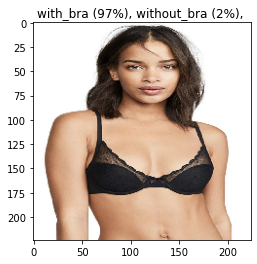

In [314]:
plt.figure()
plt.title(tags)
plt.imshow(test_images[TEST_IMAGE_INDEX]);

plt.show()

## MobileNetV2 summary

In [315]:
preds = model.evaluate(X_val, y_val)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 11s 2s/step - loss: 1.9119 - accuracy: 0.7233
Loss = 1.911897897720337
Test Accuracy = 0.7232704162597656


## ResNet-50 summary

In [316]:
preds = new_model.evaluate(X_val, y_val)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 6s 1s/step - loss: 0.6552 - accuracy: 0.8113
Loss = 0.6551517844200134
Test Accuracy = 0.8113207817077637
